# DeepCaImX introduction and guide
## Import components: Keras, SciPy input/output, Numpy, Time, and Visualization with Python.

In [1]:
import keras
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.applications import *
from tensorflow.keras import backend
from keras.constraints import *
import tensorflow as tf
import scipy.io as sio
import numpy as np
import time
import matplotlib.pyplot as plt

## Load one sample for test, and visualize the results.

Sample with  0  neuron(s)


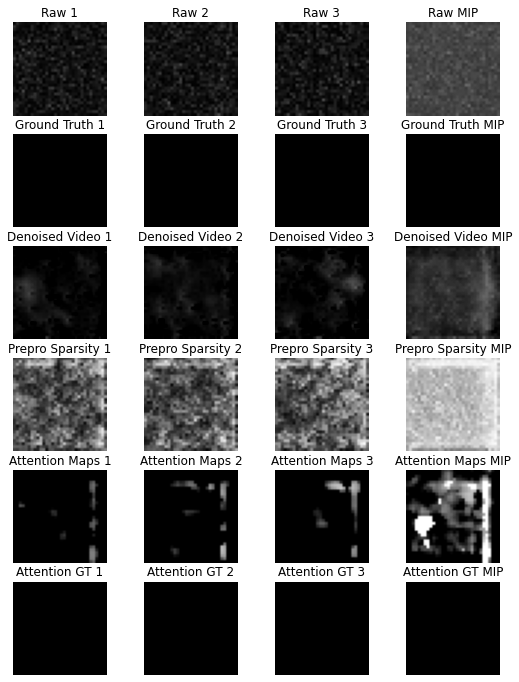

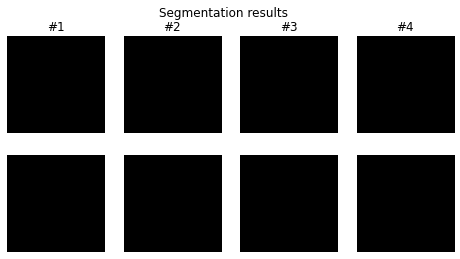

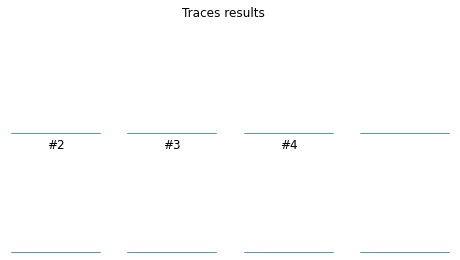

Sample with  1  neuron(s)


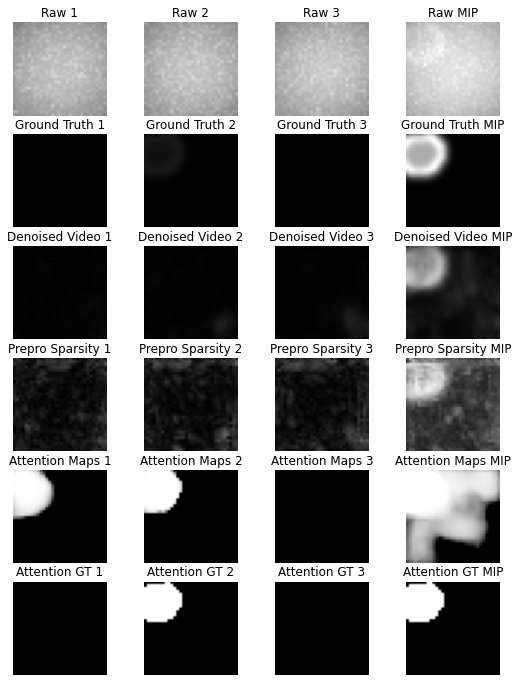

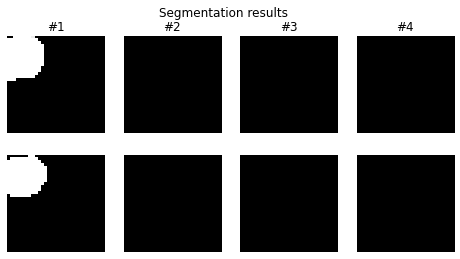

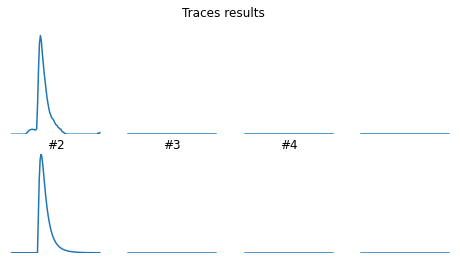

Sample with  2  neuron(s)


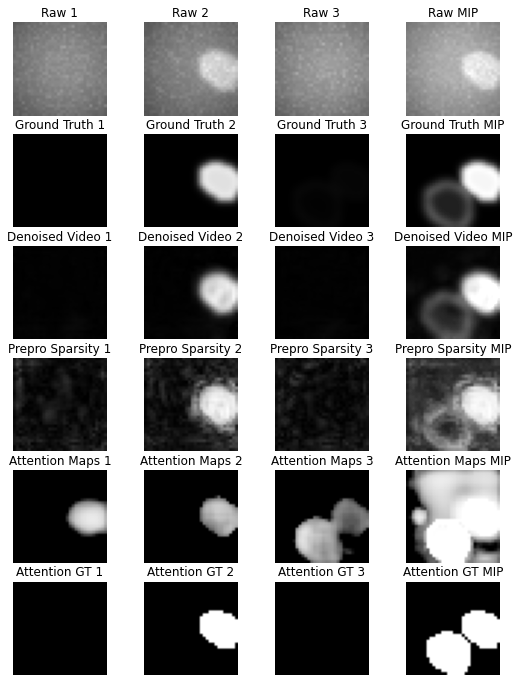

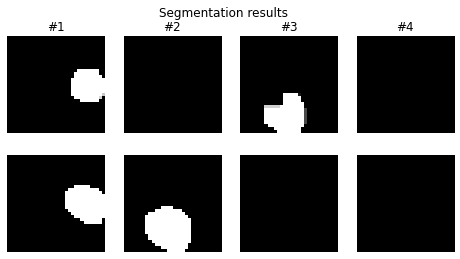

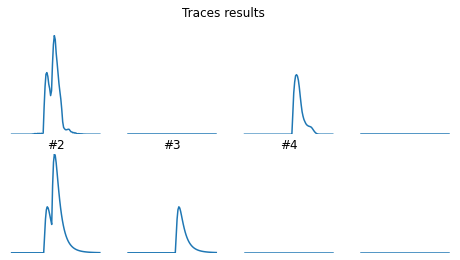

Sample with  3  neuron(s)


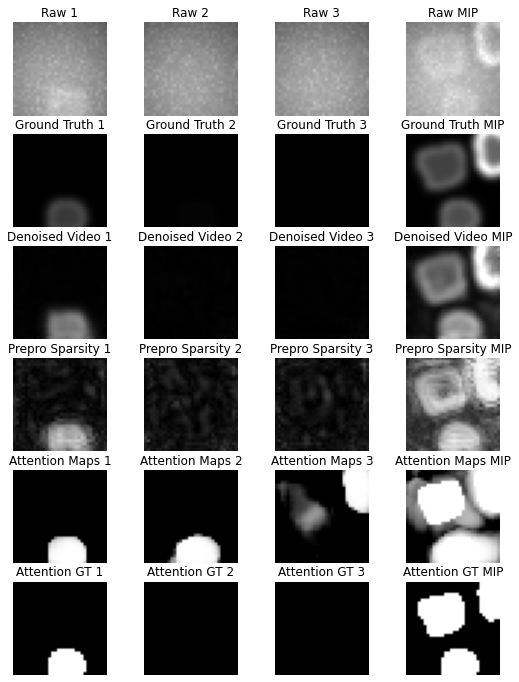

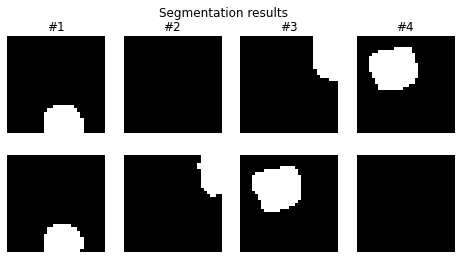

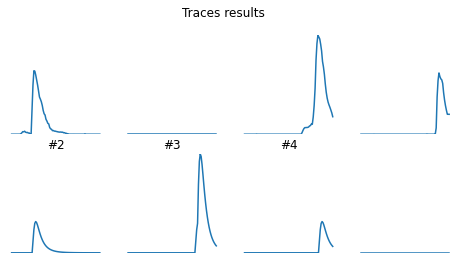

Sample with  4  neuron(s)


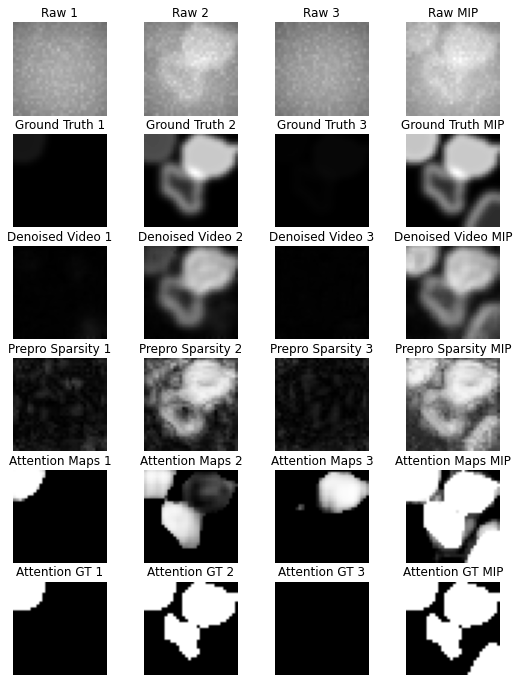

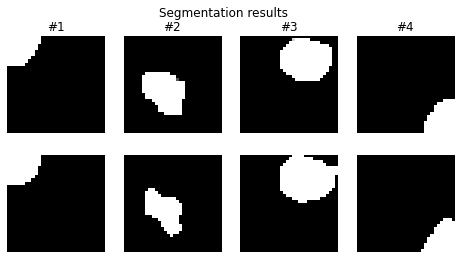

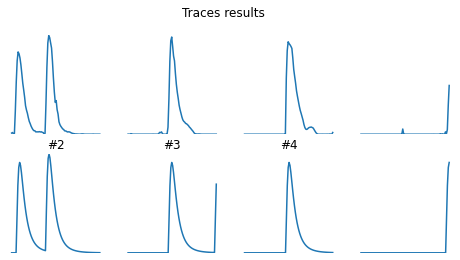

In [2]:
############## Load trained model ##############
def denoise_loss(y_true, y_pred): # MSE with contraint
    regularized_loss = backend.sum(backend.square(y_pred[:,:,:,:,0] - y_true[:,:,:,:,0])) + 0.01*backend.sum(backend.square(y_pred[:,:,:,:,5]))         
    return regularized_loss/y_true.shape[1]

def dice_coefficient(x1, x2):
    smooth = 1e-6
    intersection  = backend.sum(x1*x2)
    union = backend.sum(x1+x2)
    return (2.*intersection + smooth)/(union + smooth)
def seg_loss(y_true, y_pred):
    smooth = 1e-6
    attention_loss = 1 - dice_coefficient(y_pred[:,0:100,:,:,0], y_true[:,0:100,:,:,0])            
    seg_loss = 1 - dice_coefficient(y_pred[:,100:104,:,:,0], y_true[:,100:104,:,:,0])
    #diver_constraint = backend.mean(dice_coefficient(y_pred[:,100,:,:,0], y_pred[:,101,:,:,0]) + dice_coefficient(y_pred[:,100,:,:,0], y_pred[:,102,:,:,0]) + dice_coefficient(y_pred[:,100,:,:,0], y_pred[:,103,:,:,0]) + dice_coefficient(y_pred[:,101,:,:,0], y_pred[:,102,:,:,0] + dice_coefficient(y_pred[:,101,:,:,0], y_pred[:,103,:,:,0]) + dice_coefficient(y_pred[:,102,:,:,0], y_pred[:,103,:,:,0])))

    return 10*(0.1*attention_loss + 0.9*seg_loss)

def trace_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = y_true[:,2:98]
    pearson_correlation_loss = (backend.sum((y_pred-backend.mean(y_pred))*(y_true-backend.mean(y_true)))+smooth) / (backend.sqrt((backend.sum(backend.square(y_pred-backend.mean(y_pred)))+smooth)*(backend.sum(backend.square((y_true-backend.mean(y_true))))+smooth)))
    pearson_correlation_loss = 1 - pearson_correlation_loss
    return 10*pearson_correlation_loss

def test(DeepCaImX_model, video, data, seg_GT, trace_GT):
    # Size of "video", "data" and "att_GT" is (?,100,32,32,1)
    # Size of "seg_GT" is (?,32,32,4)
    # Size of "trace_GT" is (?,100,4)
    start_time = time.time()
    video = np.float32(video)
    seg_GT = np.float32(seg_GT)
    
    trace_GT = np.float32(trace_GT)
    att_GT = np.float32(np.zeros_like(data))
    for k in range(trace_GT.shape[0]):
        for i in range(trace_GT.shape[1]):
            for j in range(seg_GT.shape[3]):
                att_GT[k,i,:,:,0] = att_GT[k,i,:,:,0] + seg_GT[k,:,:,j]*trace_GT[k,i,j]                
    att_GT[att_GT>=0.05] = 1
    att_GT[att_GT<0.05] = 0

    seg_GT = np.transpose(seg_GT,[0,3,1,2])
    seg_GT = np.expand_dims(seg_GT,axis=4)
    seg_GT = np.append(att_GT,seg_GT,axis=1)
    seg_gt = np.zeros([1,104,32,32,1])
    seg_gt[:,0:seg_GT.shape[1],:,:,:] = seg_GT
    seg_GT = seg_gt

    [img, seg, trace] = DeepCaImX_model.predict_on_batch(np.expand_dims(video[0], axis=0))
    img_denoised = img[0,:,:,:,0]
    img_sparse = img[0,:,:,:,1:5]
    img_sparse = np.amax(img_sparse,axis=3)
    img_GT = data[0,:,:,:,0]
    img_raw = video[0,:,:,:,0]
    att = seg[0,0:400,:,:,0]
    att_GT = att_GT[0,:,:,:,0]
    
    plt.figure(figsize=(9,12))
    plt.subplot(6,4,1)
    plt.imshow(img_raw[25,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Raw 1')
    plt.subplot(6,4,2)
    plt.imshow(img_raw[50,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Raw 2')
    plt.subplot(6,4,3)
    plt.imshow(img_raw[75,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Raw 3')
    plt.subplot(6,4,4)
    plt.imshow(np.amax(img_raw,axis=0),vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Raw MIP')

    plt.subplot(6,4,5)
    plt.imshow(img_GT[25,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Ground Truth 1')
    plt.subplot(6,4,6)
    plt.imshow(img_GT[50,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Ground Truth 2')
    plt.subplot(6,4,7)
    plt.imshow(img_GT[75,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Ground Truth 3')
    plt.subplot(6,4,8)
    plt.imshow(np.amax(img_GT,axis=0),vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Ground Truth MIP')

    plt.subplot(6,4,9)
    plt.imshow(img_denoised[25,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Denoised Video 1')
    plt.subplot(6,4,10)
    plt.imshow(img_denoised[50,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Denoised Video 2')
    plt.subplot(6,4,11)
    plt.imshow(img_denoised[75,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Denoised Video 3')
    plt.subplot(6,4,12)
    plt.imshow(np.amax(img_denoised,axis=0),vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Denoised Video MIP')

    plt.subplot(6,4,13)
    plt.imshow(img_sparse[25,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Prepro Sparsity 1')
    plt.subplot(6,4,14)
    plt.imshow(img_sparse[50,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Prepro Sparsity 2')
    plt.subplot(6,4,15)
    plt.imshow(img_sparse[75,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Prepro Sparsity 3')
    plt.subplot(6,4,16)
    plt.imshow(np.amax(img_sparse,axis=0),vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Prepro Sparsity MIP')

    plt.subplot(6,4,17)
    plt.imshow(att[25,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention Maps 1')
    plt.subplot(6,4,18)
    plt.imshow(att[50,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention Maps 2')
    plt.subplot(6,4,19)
    plt.imshow(att[75,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention Maps 3')
    plt.subplot(6,4,20)
    plt.imshow(np.amax(att,axis=0,keepdims=False),vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention Maps MIP')

    plt.subplot(6,4,21)
    plt.imshow(att_GT[25,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention GT 1')
    plt.subplot(6,4,22)
    plt.imshow(att_GT[50,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention GT 2')
    plt.subplot(6,4,23)
    plt.imshow(att_GT[75,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention GT 3')
    plt.subplot(6,4,24)
    plt.imshow(np.amax(att_GT,axis=0,keepdims=False),vmin=0,vmax=1,cmap='gray')
    plt.axis('off')  
    plt.title('Attention GT MIP')
    plt.show()

    plt.figure(figsize=(8,4))
    for i in range(4):
        plt.subplot(2,4,i+1)                
        plt.imshow(seg[0,104+i,:,:,0],vmin=0,vmax=1,cmap='gray')
        plt.axis('off')
        plt.title('#'+str(i+1))
        plt.subplot(2,4,i+5)
        plt.imshow(seg_GT[0,100+i,:,:,0],vmin=0,vmax=1,cmap='gray')
        plt.axis('off')
    plt.suptitle('Segmentation results')
    plt.show()
    trace = trace[0]
    trace = trace/(np.amax(trace)+1e-3)
    for i in range(4):
        if np.sum(seg[0,104+i,:,:,0]) == 0:
            trace[:,i] = 0
            
    trace_GT = trace_GT[0]
    trace_gt = np.zeros([trace_GT.shape[0],4])
    trace_gt[:,0:trace_GT.shape[1]] = trace_GT
    trace_GT = trace_gt
    plt.figure(figsize=(8,4))
    for i in range(4):
        plt.title('#'+str(i+1))
        plt.subplot(2,4,i+1)
        plt.plot(trace[:,i])
        plt.ylim(0,1)
        plt.axis('off')                
        plt.subplot(2,4,i+5)
        plt.plot(trace_GT[:,i])
        plt.ylim(0,1)
        plt.axis('off')
    plt.suptitle('Traces results')
    plt.show()
    return img, seg, trace


config=tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
DeepCaImX_model = load_model('./Pretrained Model/DeepCaImX_model.h5',custom_objects={'backend': backend,'dice_coefficient': dice_coefficient,'denoise_loss': denoise_loss,'seg_loss': seg_loss,'trace_loss': trace_loss})
################################################

############## Load test sample ##############
## Allocate GPU memory in real-time
for i in range(5):
    LSTM_Video = sio.loadmat("./Testing Dataset/LSTM_Video_"+str(i+1)+".mat")
    LSTM_Video = LSTM_Video['LSTM_video']
    LSTM_Video = np.transpose(LSTM_Video,[2,0,1])
    LSTM_Video = np.expand_dims(np.expand_dims(LSTM_Video,3),0)

    LSTM_Data = sio.loadmat("./Testing Dataset/LSTM_Data_"+str(i+1)+".mat")
    LSTM_Data = LSTM_Data['LSTM_data']
    LSTM_Data = np.transpose(LSTM_Data,[2,0,1])
    LSTM_Data = np.expand_dims(np.expand_dims(LSTM_Data,3),0)

    LSTM_Masks = sio.loadmat("./Testing Dataset/LSTM_Masks_"+str(i+1)+".mat")
    LSTM_Masks = LSTM_Masks['LSTM_mask']
    LSTM_Masks = np.float32(np.expand_dims(LSTM_Masks,0))

    LSTM_Trace = sio.loadmat("./Testing Dataset/LSTM_Trace_"+str(i+1)+".mat")
    LSTM_Trace = LSTM_Trace['LSTM_trace']
    LSTM_Trace = np.transpose(LSTM_Trace,[1,0])
    LSTM_Trace = np.expand_dims(LSTM_Trace,0)
################################################

############## Predict and visualizeROIs segmentation results and traces extraction results ##############
    print('Sample with ',str(i),' neuron(s)')
    [img, seg, trace] = test(DeepCaImX_model, LSTM_Video, LSTM_Data, LSTM_Masks, LSTM_Trace)
    # (Optional) Save output in a format of .mat
    #sio.savemat('img'+str(i+1)+'.mat',{'img': np.array(img)})
    #sio.savemat('seg'+str(i+1)+'.mat',{'seg': np.array(seg)})
    #sio.savemat('trace'+str(i+1)+'.mat',{'trace': np.array(trace)})
##############################################################